In [1]:
from gams.transfer import Container
import pandas as pd
from utils import read_gdx,read_scenarios,calc_cum_emis,gini
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

['C', 'CPC', 'K', 'I', 'S', 'RI', 'YGROSS', 'YNET', 'Y', 'CTX', 'E', 'EIND', 'MIU', 'ABATEDEMI', 'CCO2EIND', 'CCO2ETOT', 'UTILITY', 'ABATECOST', 'CPRICE', 'ABATECOST_PB', 'ABATECOST_ED', 'CPRICE_ED', 'CPRICE_PB', 'ELAND', 'FORC', 'TATM', 'TOCEAN', 'W_EMI', 'WCUM_EMI', 'RF', 'RFoth', 'TEMP_REGION', 'TEMP_REGION_DAM', 'DAMAGES', 'DAMFRAC', 'YNET_ESTIMATED', 'BIMPACT', 'OMEGA', 'KOMEGA']


## Read data

In [98]:
path_format_gamma = 'results/Gamma scenarios/Budget {}/results_gamma{}_{}_{}.gdx'

budgets = [750]
ssps = ['ssp2']
gammas = [0,0.5,0.8,1.2,1.5]

path_format_sharing = 'results/Effort sharing scenarios/Budget {}/results_approach_{}_{}_{}.gdx'
approaches = ['percapita','hist_emis_inv','gdp_percapita_inv','current_emis_percapita']

paths_bau = ['results/results_baunoncoop.gdx','results/results_baucoop.gdx']
paths_gamma = [path_format_gamma.format(budget,gamma,ssp,budget) for ssp in ssps for budget in budgets for gamma in gammas]
paths_sharing = [path_format_sharing.format(budget,approach,ssp,budget) for ssp in ssps for budget in budgets for approach in approaches]

paths = paths_bau + paths_gamma + paths_sharing
paths

['results/results_baunoncoop.gdx',
 'results/results_baucoop.gdx',
 'results/Gamma scenarios/Budget 750/results_gamma0_ssp2_750.gdx',
 'results/Gamma scenarios/Budget 750/results_gamma0.5_ssp2_750.gdx',
 'results/Gamma scenarios/Budget 750/results_gamma0.8_ssp2_750.gdx',
 'results/Gamma scenarios/Budget 750/results_gamma1.2_ssp2_750.gdx',
 'results/Gamma scenarios/Budget 750/results_gamma1.5_ssp2_750.gdx',
 'results/Effort sharing scenarios/Budget 750/results_approach_percapita_ssp2_750.gdx',
 'results/Effort sharing scenarios/Budget 750/results_approach_hist_emis_inv_ssp2_750.gdx',
 'results/Effort sharing scenarios/Budget 750/results_approach_gdp_percapita_inv_ssp2_750.gdx',
 'results/Effort sharing scenarios/Budget 750/results_approach_current_emis_percapita_ssp2_750.gdx']

In [99]:
# Read all the data
vars = ['E','EIND','MIU','ABATEDEMI','ABATECOST','CPC','TEMP_REGION','Y','YGROSS','YNET']

data = read_scenarios(paths,vars)
data['E'] = data['E']*5 #Adjust timestep
data['ABATEDEMI'] = data['ABATEDEMI']*5 #Adjust timestep
data['EIND'] = data['EIND']*5 #Adjust timestep
data['scen'] = data['scen'].str.replace('_ssp2_750','')
data

,t,region,E,EIND,MIU,ABATEDEMI,ABATECOST,CPC,TEMP_REGION,Y,YGROSS,YNET,year,scen
0,1,arg,1.512417,1.033265,0.0,0.0,0.0,21.600981,18.437145,1.096791,1.096791,1.096791,2015,baunoncoop
1,1,aus,1.904260,2.006080,0.0,0.0,0.0,35.647058,18.061103,1.093927,1.093927,1.093927,2015,baunoncoop
2,1,aut,0.311107,0.334286,0.0,0.0,0.0,26.861917,8.505826,0.314585,0.314585,0.314585,2015,baunoncoop
3,1,bel,0.491805,0.505200,0.0,0.0,0.0,25.385417,10.677859,0.372393,0.372393,0.372393,2015,baunoncoop
4,1,bgr,0.189070,0.240366,0.0,0.0,0.0,13.120538,11.844018,0.121032,0.121032,0.121032,2015,baunoncoop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,58,tur,0.178020,0.460020,0.0,0.0,0.0,112.847319,17.041805,11.921159,11.921159,11.921159,2300,current_emis_percapita
3302,58,ukr,0.081706,0.153389,0.0,0.0,0.0,97.400953,13.650545,3.478542,3.478542,3.478542,2300,current_emis_percapita
3303,58,usa,1.071576,2.231376,0.0,0.0,0.0,90.713663,17.038120,56.407554,56.407554,56.407554,2300,current_emis_percapita
3304,58,vnm,0.292023,0.293663,0.0,0.0,0.0,157.316220,27.015578,11.890059,11.890059,11.890059,2300,current_emis_percapita


In [100]:
def type_scen(scen):
    if 'bau' in scen:
        return 'bau'
    if 'gamma' in scen:
        return 'gamma'
    return 'sharing'

data['type_scen'] = data['scen'].apply(type_scen)

In [101]:
# Populations
pops = pd.DataFrame()
param = 'pop'

for path in paths:
    gdx = Container(path)
    pop_scen = gdx[param].records.rename(columns={'t_0':'t','n_1':'region','value':param})
    pop_scen['scen'] = path.split('/')[-1].replace("results_","").replace(".gdx","")
    pop_scen['region'] = pop_scen['region'].astype(str)
    pops = pd.concat([pops,pop_scen])

data['pop'] = pops['pop']
data['GDP percapita (USD)'] = 1000000*data['Y']/data['pop']
data['Emis per capita (ton)'] = 1000 * data['E'] / data['pop']
data['Abate percapita (USD)'] = 1000000 * data['ABATECOST'] / data['pop']
century = data[data['year'] <= 2100]
century

,t,region,E,EIND,MIU,ABATEDEMI,ABATECOST,CPC,TEMP_REGION,Y,YGROSS,YNET,year,scen,type_scen,pop,GDP percapita (USD),Emis per capita (ton),Abate percapita (USD)
0,1,arg,1.512417,1.033265,0.000000,0.000000,0.000000,21.600981,18.437145,1.096791,1.096791,1.096791,2015,baunoncoop,bau,43.127916,25431.109242,35.068165,0.000000
1,1,aus,1.904260,2.006080,0.000000,0.000000,0.000000,35.647058,18.061103,1.093927,1.093927,1.093927,2015,baunoncoop,bau,23.842515,45881.351934,79.868245,0.000000
2,1,aut,0.311107,0.334286,0.000000,0.000000,0.000000,26.861917,8.505826,0.314585,0.314585,0.314585,2015,baunoncoop,bau,8.640622,36407.635428,36.005209,0.000000
3,1,bel,0.491805,0.505200,0.000000,0.000000,0.000000,25.385417,10.677859,0.372393,0.372393,0.372393,2015,baunoncoop,bau,11.269848,33043.343801,43.639001,0.000000
4,1,bgr,0.189070,0.240366,0.000000,0.000000,0.000000,13.120538,11.844018,0.121032,0.121032,0.121032,2015,baunoncoop,bau,7.174163,16870.472632,26.354247,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,18,tur,-1.531097,-1.249097,1.178467,8.248117,0.556653,52.796060,13.928119,6.423504,6.980157,6.980157,2100,current_emis_percapita,sharing,91.402574,70277.056817,-16.751136,6090.127015
1022,18,ukr,-0.815195,-0.743513,1.122605,6.807807,0.303322,40.283392,10.195912,1.655949,1.959271,1.959271,2100,current_emis_percapita,sharing,33.600531,49283.416228,-24.261385,9027.312159
1023,18,usa,-14.470435,-13.310635,1.369818,49.303004,6.001789,58.300704,13.784214,33.729957,39.731746,39.731746,2100,current_emis_percapita,sharing,455.344671,74075.659438,-31.779080,13180.759966
1024,18,vnm,-1.361749,-1.360109,1.282869,6.168384,0.374206,55.610224,24.639244,6.113185,6.487392,6.487392,2100,current_emis_percapita,sharing,78.522116,77853.040562,-17.342241,4765.614654


## Mitigation effort

Determine BAU emissions: Start by estimating the expected emissions under the BAU scenario. This represents the projected emissions without implementing any mitigation measures or policies. It serves as a baseline against which the emissions reduction will be measured.

Calculate emissions under the no-impacts reference: The no-impacts reference refers to a scenario where no mitigation measures are taken, but external factors (such as changes in technology or market conditions) naturally reduce emissions compared to the BAU scenario. Estimate the emissions that would occur under this no-impacts reference scenario.

Calculate the emissions reduction: Calculate the difference between the BAU emissions and the emissions under the no-impacts reference. This represents the emissions reduction achieved through natural changes or external factors.

Emissions Reduction = BAU emissions - Emissions under no-impacts reference

Calculate the mitigation efforts: Determine the percentage of emissions reduced relative to the BAU emissions by dividing the emissions reduction by the BAU emissions and multiplying by 100.

Mitigation Efforts = (Emissions Reduction / BAU emissions) * 100

In [18]:
effort = century[['year','region','E','scen','type_scen']].merge(ref,'left',['year','region'])
effort['reduced E'] = effort['base_E'] - effort['E']
effort

,year,region,E,scen,type_scen,base_E,reduced E
0,2015,arg,1.512417,baunoncoop,bau,1.512417,0.000000
1,2015,aus,1.904260,baunoncoop,bau,1.904260,0.000000
2,2015,aut,0.311107,baunoncoop,bau,0.311107,0.000000
3,2015,bel,0.491805,baunoncoop,bau,0.491805,0.000000
4,2015,bgr,0.189070,baunoncoop,bau,0.189070,0.000000
...,...,...,...,...,...,...,...
11281,2100,tur,-1.193265,current_emis_percapita,sharing,6.934801,8.128066
11282,2100,ukr,-0.455019,current_emis_percapita,sharing,6.373894,6.828913
11283,2100,usa,-13.382053,current_emis_percapita,sharing,37.225753,50.607806
11284,2100,vnm,-1.205517,current_emis_percapita,sharing,4.923731,6.129249


In [202]:
effort.describe()

,year,E,base_E,reduced E,Mitigation effort
count,11286.000000,11286.000000,11286.000000,11286.000000,11286.000000
mean,2057.500000,1.662434,5.129638,3.467204,0.435203
std,25.941787,7.048016,12.070971,11.351073,1.028036
min,2015.000000,-47.082132,-0.042020,-2.511194,-34.606935
25%,2035.000000,0.035214,0.262793,0.000000,0.000000
50%,2057.500000,0.327364,1.445444,0.210600,0.409868
75%,2080.000000,1.439380,4.170031,1.956776,0.865396
max,2100.000000,82.800132,82.800132,109.133745,14.566878


In [68]:
final_y = 2050

perc_reduced_years = pd.DataFrame()
for final_y in range(2015,2101,5):
    initial = century[(century['year'] == 2015) & (century['type_scen'] != 'bau')][['region','E','scen']].set_index(['scen','region'])
    final = century[(century['year'] == final_y) & (century['type_scen'] != 'bau')][['region','E','scen']].set_index(['scen','region'])
    reduced = initial - final
    perc_reduced = reduced/initial
    perc_reduced = perc_reduced.reset_index().rename(columns={'E':'Emissions reduced'})
    perc_reduced['year'] = final_y
    perc_reduced_years = pd.concat([perc_reduced_years,perc_reduced])
perc_reduced_years

,scen,region,Emissions reduced,year
0,gamma0,arg,0.000000,2015
1,gamma0,aus,0.000000,2015
2,gamma0,aut,0.000000,2015
3,gamma0,bel,0.000000,2015
4,gamma0,bgr,0.000000,2015
...,...,...,...,...
508,current_emis_percapita,tur,1.732239,2100
509,current_emis_percapita,ukr,1.434515,2100
510,current_emis_percapita,usa,1.511283,2100
511,current_emis_percapita,vnm,2.180320,2100


In [197]:
final_y = 2100
effort_final = effort[effort['year'] == final_y]

max_regions = []
for scen in effort_final['scen'].unique():
    scen_mitigation = effort_final[effort_final['scen'] == scen].set_index('region')
    max_region = scen_mitigation['Mitigation effort'].idxmax()
    max_regions.append((scen,max_region,scen_mitigation.loc[max_region,'Mitigation effort']))

max_regions

[('baunoncoop', 'chl', 0.14063282119605292),
 ('baucoop', 'arg', 0.0),
 ('gamma0', 'chl', 3.26569628346501),
 ('gamma0.5', 'chl', 3.455215218916639),
 ('gamma0.8', 'chl', 3.595814802773058),
 ('gamma1.2', 'chl', 3.549216743571043),
 ('gamma1.5', 'chl', 3.999364640870998),
 ('percapita', 'rcz', 3.737486669059363),
 ('hist_emis_inv', 'chn', 1.6597813177391434),
 ('gdp_percapita_inv', 'chn', 1.6583289746289223),
 ('current_emis_percapita', 'chn', 1.6486182532763034)]

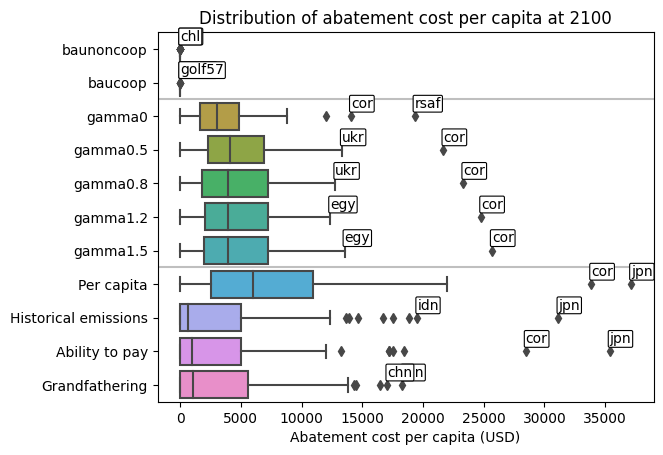

In [218]:
abatement_dist = century[century['year'] == 2100].replace({'percapita':'Per capita','hist_emis_inv':'Historical emissions','gdp_percapita_inv':'Ability to pay','current_emis_percapita':'Grandfathering'})
sns.boxplot(data=abatement_dist,y='scen',x='Abate percapita (USD)',orient='h')

bbox_props = dict(boxstyle='round', fc='white', ec='black', lw=0.8, pad=0.1)
i=0
for scen in abatement_dist['scen'].unique():
    scen_mitigation = abatement_dist[abatement_dist['scen'] == scen].set_index('region')
    scen_mitigation = scen_mitigation[['Abate percapita (USD)']]
    top_values = scen_mitigation.nlargest(2,'Abate percapita (USD)')
    
    for reg,row in top_values.iterrows():
        value = row['Abate percapita (USD)']
        plt.annotate(reg,xy=(value-0.1,i-0.25),bbox=bbox_props)
    i += 1

plt.title(f'Distribution of abatement cost per capita at {final_y}')
plt.xlabel('Abatement cost per capita (USD)')
plt.axhline(6.5,alpha=0.5,color='gray')
plt.axhline(1.5,alpha=0.5,color='gray')
plt.ylabel('')
plt.show()

## Cumulative emissions and budget

In [9]:
cum_emis = century.pivot_table('E',['scen','year'],'region').cumsum()
cum_emis

region                 arg         aus        aut        bel        bgr  \
scen      year                                                            
baucoop   2015    1.512417    1.904260   0.311107   0.491805   0.189070   
          2020    2.976310    3.837939   0.618881   0.998944   0.356020   
          2025    4.402161    5.771796   0.919829   1.523402   0.506381   
          2030    5.798463    7.689526   1.213121   2.066426   0.644420   
          2035    7.172399    9.587888   1.499518   2.627261   0.772317   
...                    ...         ...        ...        ...        ...   
percapita 2080  148.192089  171.889782  31.623709  61.496713  13.292344   
          2085  147.827677  171.275965  31.562210  61.367261  13.277322   
          2090  147.316077  170.478204  31.470223  61.220843  13.256746   
          2095  146.636665  169.471940  31.369862  61.059811  13.230890   
          2100  146.042124  168.566619  31.283598  60.924679  13.211544   

region                blt         bra         can        chl          chn  \
scen      year                                                              
baucoop   2015   0.154299    4.960544    3.404415   0.184226    49.094535   
          2020   0.319203    9.854580    6.883838   0.424614   111.582217   
          2025   0.488478   14.689595   10.370864   0.707974   184.683777   
          2030   0.660452   19.468000   13.840514   1.020329   264.253340   
          2035   0.835020   24.204010   17.286952   1.350135   346.404959   
...                   ...         ...         ...        ...          ...   
percapita 2080  20.273287  315.701054  264.416251  18.791077  3503.517203   
          2085  20.227187  314.329375  263.263756  18.773521  3481.829457   
          2090  20.176129  312.377401  262.015420  18.807174  3456.733653   
          2095  20.090133  309.898289  260.675051  18.856494  3428.105959   
          2100  20.043137  308.445432  259.584767  18.932622  3404.083501   

region          ...         rus       slo        sui        swe         tha  \
scen      year  ...                                                           
baucoop   2015  ...    7.893869  0.033622   0.181673   0.208256    1.839591   
          2020  ...   15.821936  0.060539   0.358503   0.423363    3.745111   
          2025  ...   23.827118  0.082377   0.533537   0.643171    5.716374   
          2030  ...   31.937666  0.100851   0.709399   0.866624    7.726760   
          2035  ...   40.097289  0.117312   0.889312   1.093853    9.742038   
...             ...         ...       ...        ...        ...         ...   
percapita 2080  ...  492.751713  3.342949  29.163050  31.763022  170.687245   
          2085  ...  490.050268  3.357135  29.138337  31.758977  170.324351   
          2090  ...  486.648343  3.372558  29.104276  31.732053  169.845524   
          2095  ...  482.446476  3.384644  29.020891  31.688177  169.247826   
          2100  ...  478.788819  3.400130  28.956989  31.649603  168.737831   

region                 tur         ukr          usa         vnm         zaf  
scen      year                                                               
baucoop   2015    1.629611    1.047187    26.173457    1.021348    2.210207  
          2020    3.550256    2.236015    50.683520    2.332736    4.490070  
          2025    5.755397    3.647542    74.500207    3.920137    6.850584  
          2030    8.240484    5.326208    98.246913    5.779004    9.275929  
          2035   11.005430    7.297011   122.312853    7.896020   11.784668  
...                    ...         ...          ...         ...         ...  
percapita 2080  259.655987  229.127859  1648.649190  201.545409  256.438795  
          2085  259.140706  228.453173  1639.615482  201.323537  255.766284  
          2090  258.137536  227.379191  1627.685655  200.751338  254.816037  
          2095  256.560471  225.820389  1612.386771  199.786572  253.539647  
          2100  255.118105  224.388877  1598.854031  199.0

In [38]:
budgets = cum_emis.loc[2100,:]

## Region shares by approach

In [175]:
approaches = ['percapita','hist_emis_inv','gdp_percapita_inv','current_emis_percapita']
all_shares = pd.read_csv('all_shares.csv')

shares = all_shares[(all_shares['ssp'] == 'SSP2') & (all_shares['region_def'] == 'ed57') & (all_shares['approach'].isin(approaches))]
shares = shares.drop(columns=['region_def','ssp']).rename(columns={'n':'Region','approach':'Approach'})
shares = shares.replace({'percapita':'Per capita','hist_emis_inv':'Historical emissions','gdp_percapita_inv':'Ability to pay','current_emis_percapita':'Grandfathering'})

shares_by_approach = shares.pivot_table('budget_share','Approach','Region')
shares_by_approach = shares_by_approach #.sort_values(by='asia')
shares_by_approach.sort_values('Ability to pay',axis=1,ascending=False)

Region,rsaf,rsas,rcam,vnm,nde,osea,rjan57,ris,noap,oeu,...,aus,swe,bel,usa,aut,nld,rcz,nor,sui,cor
Approach,,,,,,,,,,,,,,,,,,,,,
Ability to pay,0.049088,0.047002,0.031993,0.030680,0.030380,0.029714,0.028817,0.024852,0.024347,0.024257,...,0.010428,0.010366,0.010313,0.009807,0.009763,0.009706,0.009545,0.009307,0.009050,0.008170
Grandfathering,0.005504,0.002428,0.009243,0.006404,0.004855,0.010903,0.016240,0.016740,0.013098,0.008871,...,0.045688,0.012338,0.025883,0.046957,0.021060,0.028528,0.025686,0.012995,0.013319,0.035586
Historical emissions,0.017410,0.018258,0.018023,0.019855,0.014870,0.015978,0.020713,0.015324,0.018301,0.018329,...,0.016295,0.018678,0.016840,0.012290,0.018507,0.017013,0.016931,0.020318,0.019903,0.016446
Per capita,0.200697,0.070137,0.011362,0.010783,0.185402,0.028914,0.002520,0.010859,0.006316,0.002416,...,0.004104,0.001451,0.001408,0.045929,0.001000,0.002088,0.001283,0.000817,0.001014,0.004754


In [177]:
budgets = {}
gamma_scens = century[century['type_scen'] == 'gamma']
gamma_scens['gamma'] = gamma_scens['scen'].str.replace('gamma','')
for gamma in gamma_scens['gamma'].unique():
    emis = gamma_scens[gamma_scens['gamma'] == gamma]
    emis = emis.pivot_table('E','year','region').cumsum()
    budget_2100 = emis.loc[2100,:]
    budgets[gamma] = budget_2100 / budget_2100.sum()

budgets = pd.DataFrame.from_dict(budgets,orient='index')
budgets

C:\Users\danip\AppData\Local\Temp\ipykernel_22964\4144762417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamma_scens['gamma'] = gamma_scens['scen'].str.replace('gamma','')


,arg,aus,aut,bel,bgr,blt,bra,can,chl,chn,...,rus,slo,sui,swe,tha,tur,ukr,usa,vnm,zaf
0,0.011875,0.011310,0.002122,0.005007,0.000912,0.001179,0.008146,0.022081,-0.001312,0.222578,...,0.033736,0.000310,0.001750,0.001928,0.014053,0.009353,0.004838,0.147538,0.000211,0.015696
0.5,0.009386,0.007718,0.001733,0.004385,0.000286,0.000854,0.003556,0.018091,-0.001979,0.160300,...,0.023744,-0.000066,0.001156,0.001538,0.012076,0.006891,0.005827,0.098355,-0.000575,0.016850
0.8,0.008213,0.006110,0.001624,0.004111,0.000277,0.000708,0.002711,0.016378,-0.002229,0.136630,...,0.019941,0.000133,0.000897,0.001366,0.011179,0.006647,0.007053,0.077592,-0.000030,0.018075
1.2,0.006652,0.004080,0.001310,0.003703,0.000172,0.000539,0.001576,0.014276,-0.002693,0.105252,...,0.015198,0.000493,0.000542,0.001165,0.009952,0.006171,0.008651,0.053685,0.000605,0.019547
1.5,0.005515,0.002652,0.001110,0.003422,0.000340,0.000398,0.000822,0.012884,-0.003020,0.084013,...,0.011661,0.000085,0.000285,0.000986,0.008980,0.005898,0.009576,0.038202,0.000996,0.020560


In [63]:
# Top regions with highers budgets
top10_budgets = budgets.loc['gamma0',:].nlargest(10)
top10_budgets

chn       0.222545
usa       0.138349
golf57    0.064016
idn       0.059243
rsam      0.042617
nde       0.041273
jpn       0.039617
rus       0.032529
mex       0.032106
osea      0.029029
Name: gamma0, dtype: float64

C:\Users\danip\AppData\Local\Temp\ipykernel_22964\470257282.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in current_values])


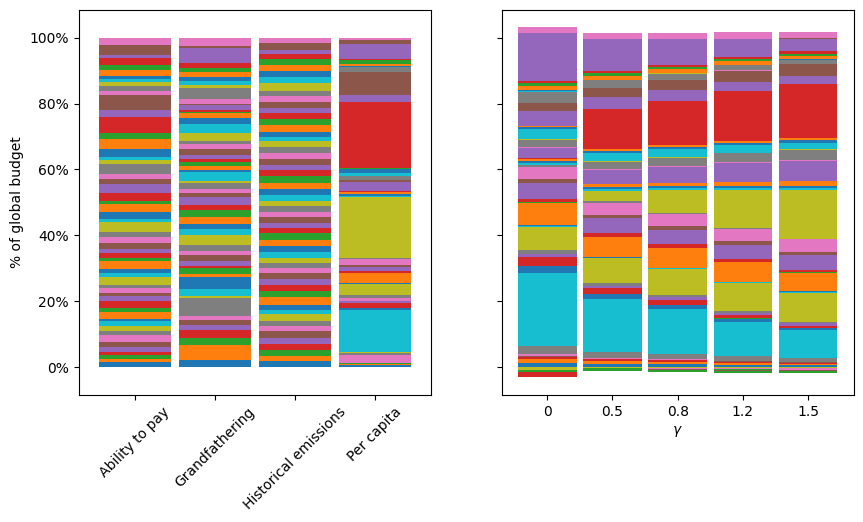

In [259]:
fig,axs = plt.subplots(1,2,sharey=True,figsize=(10,5))

shares_by_approach.plot(kind='bar',stacked=True,ax=axs[0],legend=False,width=0.9)
budgets.plot(kind='bar',stacked=True,ax=axs[1],width=0.9,legend=False)
# after plotting the data, format the labels
current_values = axs[0].get_yticks()
# using format string '{:.0f}' here but you can choose others
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in current_values])
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel('')
axs[0].set_ylabel('% of global budget')

axs[1].tick_params(axis='x', labelrotation=0)
axs[1].set_xlabel(r'$\gamma$')

# handles, labels = axs[1].get_legend_handles_labels()
# # Filter the handles and labels for the top 10 series
# top_10_handles = [h for h, l in zip(handles, labels) if l in top10_budgets]
# top_10_labels = [l for l in labels if l in top10_budgets]
# # Update the legend with the filtered handles and labels
# plt.legend(top_10_handles, top_10_labels)

plt.show()

## Region shares by approach (for r5 for plotting easier)

In [39]:
# Effort sharing approaches
approaches = ['percapita','hist_emis_inv','gdp_percapita_inv','current_emis_percapita']
region_map = {'r5oecd':'oecd','r5asia':'asia','r5lam':'latin america','r5maf':'middle east + africa','r5ref':'russia + east eur'}

all_shares = pd.read_csv('all_shares.csv')
shares = all_shares[(all_shares['ssp'] == 'SSP2') & (all_shares['region_def'] == 'r5') & (all_shares['approach'].isin(approaches))]
shares = shares.drop(columns=['region_def','ssp']).rename(columns={'n':'Region','approach':'Approach'})
shares = shares.replace({'percapita':'Per capita','hist_emis_inv':'Historical emissions','gdp_percapita_inv':'Ability to pay','current_emis_percapita':'Grandfathering'})
shares = shares.replace(region_map)

shares_by_approach = shares.pivot_table('budget_share','Approach','Region')
shares_by_approach = shares_by_approach.sort_values(by='asia')
shares_by_approach


Region,asia,latin america,middle east + africa,oecd,russia + east eur
Approach,,,,,
Grandfathering,0.139899,0.165276,0.111187,0.364466,0.219171
Historical emissions,0.192608,0.218810,0.216678,0.177256,0.194648
Ability to pay,0.223396,0.184332,0.345721,0.096435,0.150115
Per capita,0.468572,0.079701,0.267886,0.130480,0.053360


In [40]:
path_format = 'results/results_gamma{}_ssp2_1000_r5.gdx'
paths_r5 = [path_format.format(gamma) for gamma in gammas]
gamma_r5 = read_scenarios(paths_r5,['E'])
gamma_r5['gamma'] = gamma_r5['scen'].str.split('_',expand=True)[0]
gamma_r5['gamma'] = gamma_r5['gamma'].str.replace('gamma','')
gamma_r5 = gamma_r5[gamma_r5['year'] <= 2100].drop(columns=['scen'])
gamma_r5 = gamma_r5.replace(region_map)
gamma_r5

budgets = {}
for gamma in gamma_r5['gamma'].unique():
    emis = gamma_r5[gamma_r5['gamma'] == gamma]
    emis = emis.pivot_table('E','year','region').cumsum()
    budget_2100 = emis.loc[2100,:]
    budgets[gamma] = budget_2100 / budget_2100.sum()

budgets = pd.DataFrame.from_dict(budgets,orient='index')
budgets

,asia,latin america,middle east + africa,oecd,russia + east eur
0,0.356143,0.089623,0.197656,0.307324,0.049255
0.5,0.388450,0.080127,0.236157,0.255984,0.039281
0.8,0.404908,0.074693,0.259085,0.227782,0.033533
1.2,0.426216,0.067638,0.288910,0.191137,0.026099
1.5,0.440717,0.062649,0.310988,0.165037,0.020610


C:\Users\danip\AppData\Local\Temp\ipykernel_15328\3664275475.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in current_values])


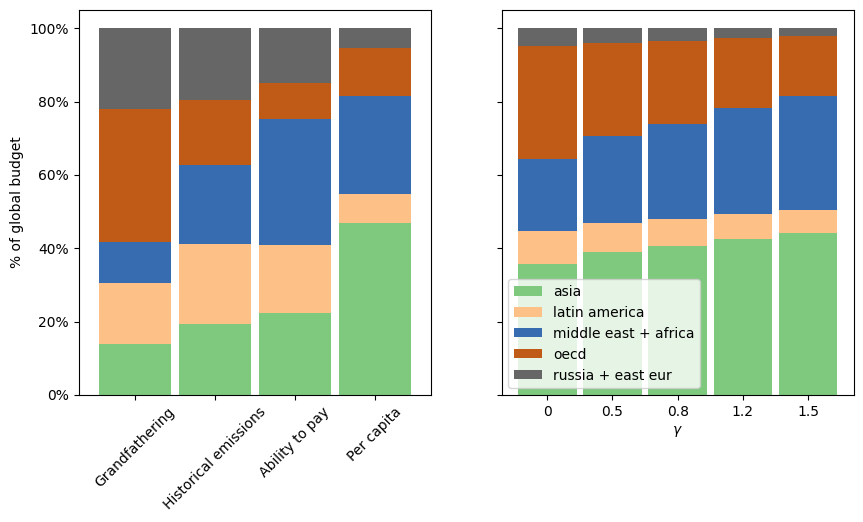

In [41]:
fig,axs = plt.subplots(1,2,sharey=True,figsize=(10,5))

shares_by_approach.plot(kind='bar',stacked=True,colormap='Accent',ax=axs[0],legend=False,width=0.9)
budgets.plot(kind='bar',stacked=True,colormap='Accent',ax=axs[1],width=0.9)
# after plotting the data, format the labels
current_values = axs[0].get_yticks()
# using format string '{:.0f}' here but you can choose others
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in current_values])
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel('')
axs[0].set_ylabel('% of global budget')

axs[1].tick_params(axis='x', labelrotation=0)
axs[1].set_xlabel(r'$\gamma$')


plt.show()

## GINI

In [222]:
century.set_index(['type_scen','scen','year'])[['region','GDP percapita (USD)']]

region  GDP percapita (USD)
type_scen scen                   year                            
bau       baunoncoop             2015    arg         25431.109242
                                 2015    aus         45881.351934
                                 2015    aut         36407.635428
                                 2015    bel         33043.343801
                                 2015    bgr         16870.472632
...                                      ...                  ...
sharing   current_emis_percapita 2100    tur         70277.056817
                                 2100    ukr         49283.416228
                                 2100    usa         74075.659438
                                 2100    vnm         77853.040562
                                 2100    zaf         45493.778813

[11286 rows x 2 columns]

   type_scen      scen  year      gini
0      gamma    gamma0  2015  0.323515
1      gamma    gamma0  2020  0.304129
2      gamma    gamma0  2025  0.285192
3      gamma    gamma0  2030  0.269407
4      gamma    gamma0  2035  0.256694
..       ...       ...   ...       ...
85     gamma  gamma1.5  2080  0.174665
86     gamma  gamma1.5  2085  0.169092
87     gamma  gamma1.5  2090  0.164458
88     gamma  gamma1.5  2095  0.160568
89     gamma  gamma1.5  2100  0.157262

[90 rows x 4 columns]


Text(0.5, 1.0, 'GINI (GDP percapita (USD))')

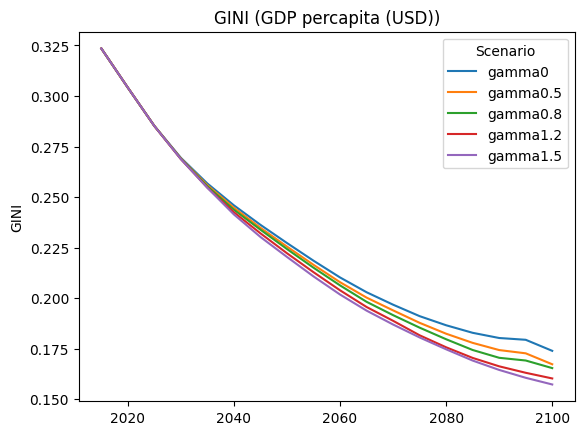

In [230]:
var = 'GDP percapita (USD)'
ginis = century[century['type_scen'] == 'gamma'].groupby(['type_scen','scen','year']).agg({var:gini}).reset_index()
ginis = ginis.rename(columns={var:'gini'})

print(ginis)
sns.lineplot(data=ginis,x='year',y='gini',hue='scen')
plt.ylabel('GINI')
plt.xlabel('')
plt.legend(title='Scenario')
plt.title(f'GINI ({var})')

    type_scen       scen  year      gini
0         bau    baucoop  2015  0.323515
1         bau    baucoop  2020  0.304128
2         bau    baucoop  2025  0.285185
3         bau    baucoop  2030  0.269272
4         bau    baucoop  2035  0.256317
..        ...        ...   ...       ...
193   sharing  percapita  2080  0.188262
194   sharing  percapita  2085  0.185592
195   sharing  percapita  2090  0.184409
196   sharing  percapita  2095  0.188316
197   sharing  percapita  2100  0.183416

[198 rows x 4 columns]


Text(0.5, 1.0, 'GINI (GDP percapita (USD))')

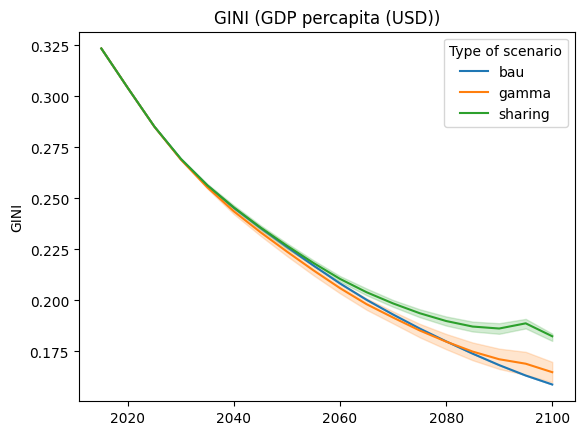

In [232]:
var = 'GDP percapita (USD)'
ginis = century.groupby(['type_scen','scen','year']).agg({var:gini}).reset_index()
ginis = ginis.rename(columns={var:'gini'})

print(ginis)
sns.lineplot(data=ginis,x='year',y='gini',hue='type_scen')
plt.ylabel('GINI')
plt.xlabel('')
plt.legend(title='Type of scenario')
plt.title(f'GINI ({var})')

    type_scen       scen  year      gini
0         bau    baucoop  2015  0.308727
1         bau    baucoop  2020  0.299453
2         bau    baucoop  2025  0.295166
3         bau    baucoop  2030  0.292629
4         bau    baucoop  2035  0.289567
..        ...        ...   ...       ...
193   sharing  percapita  2080  0.138866
194   sharing  percapita  2085  0.129081
195   sharing  percapita  2090  0.125580
196   sharing  percapita  2095  0.129339
197   sharing  percapita  2100  0.123513

[198 rows x 4 columns]


Text(0.5, 1.0, 'GINI (Emis per capita (ton))')

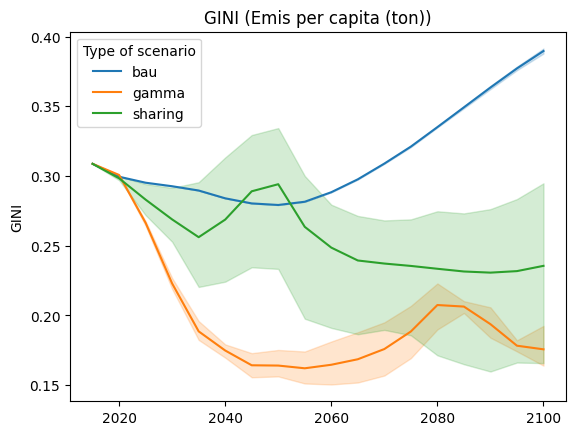

In [238]:
var = 'Emis per capita (ton)'
ginis = century.groupby(['type_scen','scen','year']).agg({var:gini}).reset_index()
ginis = ginis.rename(columns={var:'gini'})

print(ginis)
sns.lineplot(data=ginis,x='year',y='gini',hue='type_scen')
plt.ylabel('GINI')
plt.xlabel('')
plt.legend(title='Type of scenario')
plt.title(f'GINI ({var})')

    type_scen        scen  year          gini
0       gamma      gamma0  2015  7.821172e-18
1       gamma      gamma0  2020  3.497616e-01
2       gamma      gamma0  2025  3.333129e-01
3       gamma      gamma0  2030  3.347821e-01
4       gamma      gamma0  2035  3.341441e-01
..        ...         ...   ...           ...
157   sharing  Per capita  2080  4.745263e-01
158   sharing  Per capita  2085  4.640819e-01
159   sharing  Per capita  2090  4.432993e-01
160   sharing  Per capita  2095  4.535634e-01
161   sharing  Per capita  2100  4.799322e-01

[162 rows x 4 columns]


Text(0.5, 1.0, 'GINI (Abate percapita (USD))')

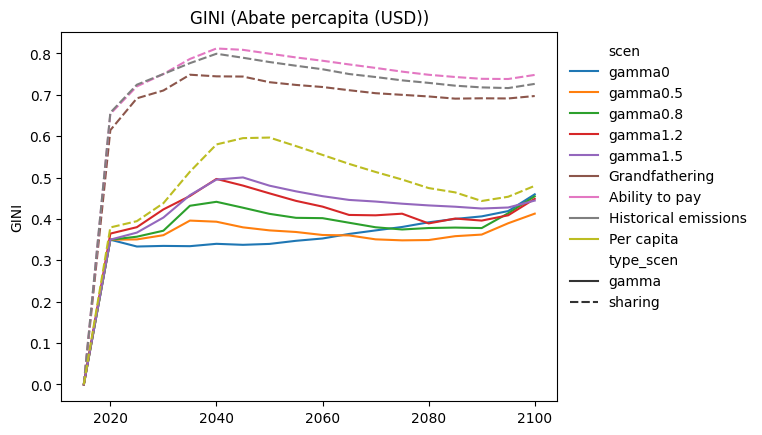

In [253]:
var = 'Abate percapita (USD)'
ginis = century[century['type_scen'] != 'bau'].groupby(['type_scen','scen','year']).agg({var:gini}).reset_index()
ginis = ginis.rename(columns={var:'gini'}).replace({'percapita':'Per capita','hist_emis_inv':'Historical emissions','gdp_percapita_inv':'Ability to pay','current_emis_percapita':'Grandfathering'})

print(ginis)
sns.lineplot(data=ginis,x='year',y='gini',hue='scen',style='type_scen')
plt.ylabel('GINI')
plt.xlabel('')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),frameon=False)
handles, labels = plt.gca().get_legend_handles_labels()
plt.title(f'GINI ({var})')

In [71]:
perc_reduced_years['type_scen'] = perc_reduced_years['scen'].apply(type_scen)
perc_reduced_years

,scen,region,Emissions reduced,year,type_scen
0,gamma0,arg,0.000000,2015,gamma
1,gamma0,aus,0.000000,2015,gamma
2,gamma0,aut,0.000000,2015,gamma
3,gamma0,bel,0.000000,2015,gamma
4,gamma0,bgr,0.000000,2015,gamma
...,...,...,...,...,...
508,current_emis_percapita,tur,1.732239,2100,sharing
509,current_emis_percapita,ukr,1.434515,2100,sharing
510,current_emis_percapita,usa,1.511283,2100,sharing
511,current_emis_percapita,vnm,2.180320,2100,sharing


    type_scen       scen  year          gini
0       gamma     gamma0  2015  7.821172e-18
1       gamma     gamma0  2020  2.419337e-01
2       gamma     gamma0  2025  2.423635e-01
3       gamma     gamma0  2030  2.189544e-01
4       gamma     gamma0  2035  1.797772e-01
..        ...        ...   ...           ...
157   sharing  percapita  2080  8.278035e-02
158   sharing  percapita  2085  7.745426e-02
159   sharing  percapita  2090  9.475913e-02
160   sharing  percapita  2095  1.219651e-01
161   sharing  percapita  2100  1.293592e-01

[162 rows x 4 columns]


Text(0.5, 1.0, 'GINI (Emissions reduced)')

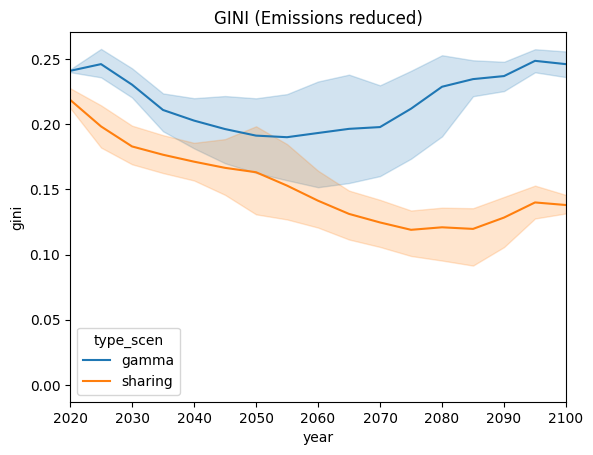

In [73]:
var = 'Emissions reduced'
ginis = perc_reduced_years.groupby(['type_scen','scen','year']).agg({var:gini}).reset_index()
ginis = ginis.rename(columns={var:'gini'})

print(ginis)
sns.lineplot(data=ginis,x='year',y='gini',hue='type_scen')
plt.xlim([2020,2100])
plt.title(f'GINI ({var})')

In [166]:
higher_mius = century[century['type_scen'] == 'gamma'].groupby('region')['MIU'].mean().nlargest(10)
miu_plot = century[century['region'].isin(higher_mius.index)]

higher_emis = century[century['type_scen'] == 'gamma'].groupby('region')['E'].mean().nlargest(10)
emis_plot = century[century['region'].isin(higher_emis.index)]

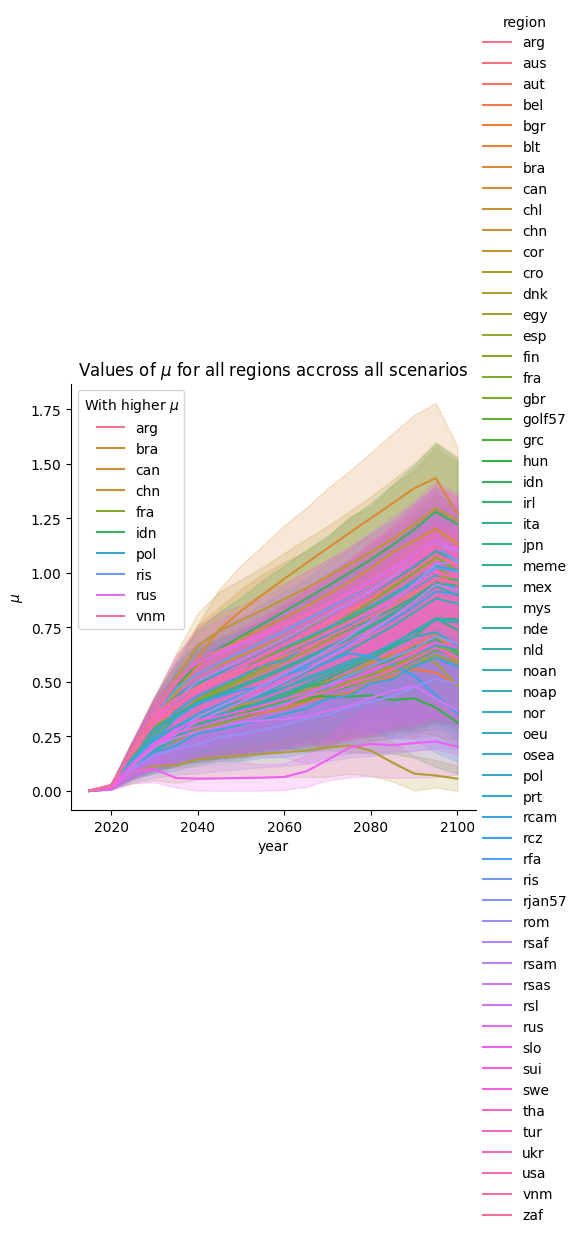

In [160]:
sns.relplot(data=century,x='year',y='MIU',kind='line',hue='region')
plt.ylabel('$\mu$')
handles, labels = plt.gca().get_legend_handles_labels()
indexes = [index for index,item in enumerate(labels) if item in higher_mius.index]
subset_handles = [handles[index] for index in indexes]
subset_labels = [labels[index] for index in indexes]
#plt.gca().get_legend().remove()
plt.legend(subset_handles, subset_labels, loc='upper left',title='With higher $\mu$')
plt.title('Values of $\mu$ for all regions accross all scenarios')
plt.show()

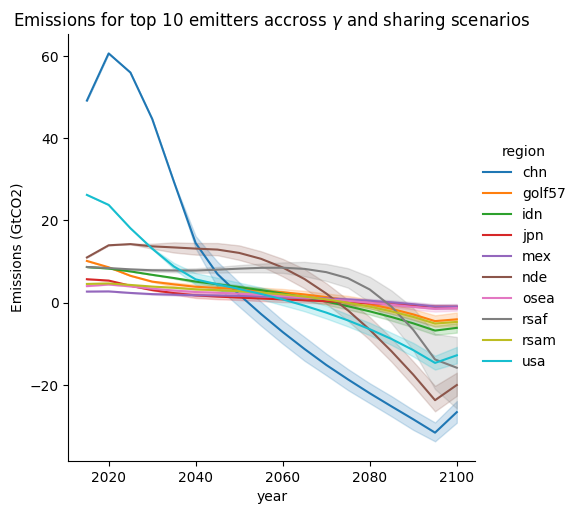

In [173]:
sns.relplot(data=emis_plot[emis_plot['type_scen'] != 'bau'],x='year',y='E',kind='line',hue='region')
plt.ylabel('Emissions (GtCO2)')
plt.title('Emissions for top 10 emitters accross $\gamma$ and sharing scenarios')
plt.show()

<Axes: xlabel='year', ylabel='ABATECOST'>

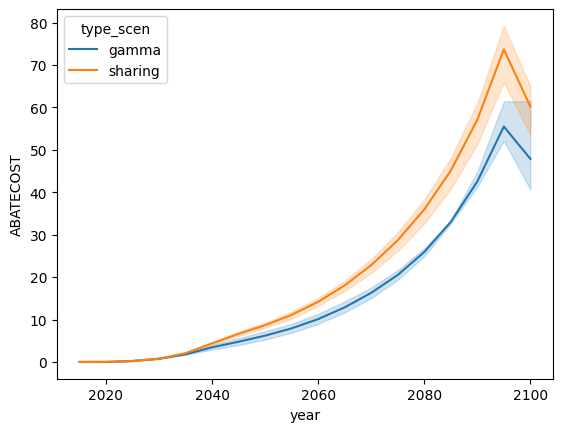

In [115]:
global_cost = century.groupby(['type_scen','scen','year'])['ABATECOST'].sum().reset_index()
global_cost = global_cost[global_cost['type_scen'] != 'bau']
sns.lineplot(data=global_cost,x='year',y='ABATECOST',hue='type_scen')

In [182]:
global_cost

,type_scen,scen,year,ABATECOST
36,gamma,gamma0,2015,1.828012e-32
37,gamma,gamma0,2020,3.639313e-03
38,gamma,gamma0,2025,2.331036e-01
39,gamma,gamma0,2030,7.254452e-01
40,gamma,gamma0,2035,1.619075e+00
...,...,...,...,...
193,sharing,percapita,2080,3.114329e+01
194,sharing,percapita,2085,3.870646e+01
195,sharing,percapita,2090,4.848822e+01
196,sharing,percapita,2095,6.187065e+01


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'gamma0'),
  Text(1, 0, 'gamma0.5'),
  Text(2, 0, 'gamma0.8'),
  Text(3, 0, 'gamma1.2'),
  Text(4, 0, 'gamma1.5'),
  Text(5, 0, 'Grandfathering'),
  Text(6, 0, 'Ability to pay'),
  Text(7, 0, 'Historical emissions'),
  Text(8, 0, 'Per capita')])

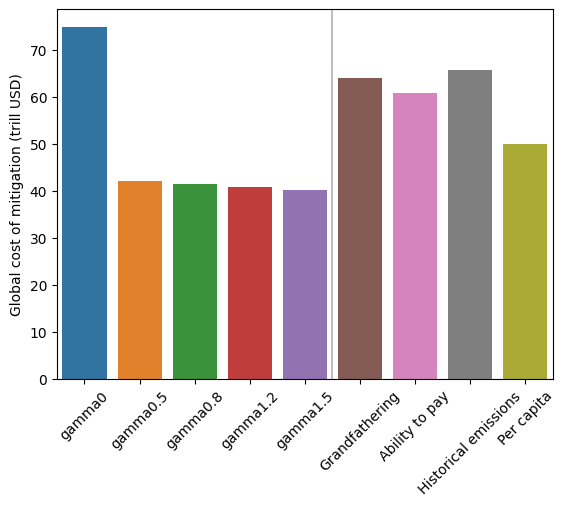

In [183]:
global_cost = global_cost.replace({'percapita':'Per capita','hist_emis_inv':'Historical emissions','gdp_percapita_inv':'Ability to pay','current_emis_percapita':'Grandfathering'})
sns.barplot(data=global_cost[global_cost['year'] == 2100],x='scen',y='ABATECOST')
plt.xlabel('')
plt.ylabel('Global cost of mitigation (trill USD)')
plt.axvline(4.5,alpha=0.5,color='gray')
plt.xticks(rotation=45)

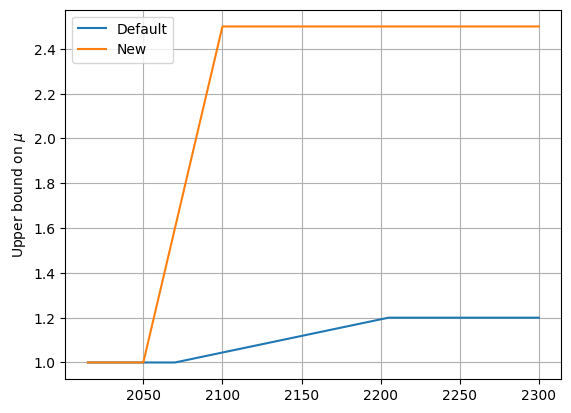

In [124]:
y2 = [2015,2070,2205,2300]
max_miu2 = [1,1,1.2,1.2]

y1 = [2015,2050,2100,2200,2300]
max_miu = [1,1,2.5,2.5,2.5]


plt.plot(y2,max_miu2,label='Default')
plt.plot(y1,max_miu,label='New')
plt.legend()
plt.grid()
plt.ylabel(r'Upper bound on $\mu$')
plt.show()